In [50]:
# Import packages
import numpy as np
import collections as col
import matplotlib.pyplot as plt
from alive_progress import alive_bar
import random
import heapq
from scipy.stats import norm

In [51]:
# Dictionary storing the number of passengers and flights recorded for each month. Each key is an integer representing the respective month and each value tied to the key is a dictionary nested within. The nested dictionary stores the number of passengers and flights in that month.
flights_month = {
    1: {"passenger": 4370000, "flights": 25200},  # January
    2: {"passenger": 4003000, "flights": 22900},  # February
    3: {"passenger": 4630000, "flights": 26100},  # March
    4: {"passenger": 4603000, "flights": 26300},  # April
    5: {"passenger": 4840000, "flights": 27600},  # May
    6: {"passenger": 5120000, "flights": 27500},  # June
    7: {"passenger": 5270000, "flights": 28900},  # July
    8: {"passenger": 5150000, "flights": 29000},  # August
    9: {"passenger": 4780000, "flights": 27800},  # September
    10: {"passenger": 5120000, "flights": 28700}, # October
    11: {"passenger": 5150000, "flights": 28000}, # November
    12: {"passenger": 5810000, "flights": 30400}, # December
}

In [52]:
# Stores number of customers cleared in a minute by a counter
CUST_PER_MIN = 4

# Stores the min and max time a passenger needs to reach the counter upon arriving at the airport
SHORTEST_TIME = 8
LONGEST_TIME = 32

# Determines the number of simulation runs
HOURS = 100

# Determines the number of counters in the airport
COUNTERS = 35

# Colour list for the plot
COLOURS = list(['blue','red','cyan','orange','green','violet'])


In [53]:

# Finding the total number of flights
total_flights = np.sum([i["flights"] for i in flights_month.values()])

# Calculating average number of flights per day
avg_daily_flights = total_flights/365

# Finding the total number of passengers
total_passengers = np.sum([i["passenger"] for i in flights_month.values()])

# Calculating the average number of passengers per flight
avg_passengers_each_flight = total_passengers/total_flights

def flight_arrival_per_minute(avg_daily_flights):
    '''
    Returns number of flights in a given minute based on a possion distribution with a rate of average daily flights per minute. 

    Args:
        avg_daily_flights(float): Average number of flights per day
    
    Returns:
        int: obtained from poisson distribution
    '''
    return np.random.poisson(avg_daily_flights/(24*60))

def passenger_arrive_flight(flights, avg_passengers_each_flight):
    '''
    Returns number of passengers given a number of flights, with a rate based on average number of passengers per flight.

    Args:
        flights(int): Number of flights
        avg_passengers_each_flight(float): Average number of passengers per flight
    
    Returns:
        int: obtained from poisson distribution
    '''

    # Stores number of passengers
    passengers = 0

    #For loop iterating through each flight
    for _ in range(flights):
        # Obtaining a value based on a poisson distribution with rate avg_passengers_each_flight
        passengers += np.random.poisson(avg_passengers_each_flight)
    
    # Returning the number of passengers
    return passengers

def passengers_cleared_per_minute():
    '''
    Returns number of passengers cleared by a counter in a minute

    Returns:
        int: obtained from an exponential distribution
    '''
    return np.random.normal(CUST_PER_MIN)

def passenger_time_to_counter():
    '''
    Returns time taken by a passenger to reach the counter based on a uniform distribution ranging from a given range.

    Returns:
        int: obtained from an exponential distribution
    '''
    return np.random.normal(avg_passengers_each_flight)
    return np.random.uniform(low = SHORTEST_TIME, high = LONGEST_TIME)

In [54]:
# Min heap storing the arrival time of each passenger
passenger_heap = []
heapq.heapify(passenger_heap)

# List storing the number of passengers in queue at each time unit (to be shown on plot)
passenger_queue = []

# Integer storing the total wait time experienced by passengers in a SINGLE cycle
passenger_wait_times = 0

# Integer storing the total number of passengers serviced in a SINGLE cycle
passengers_serviced = 0

# Deque storing the number of passengers in queue at time t
counter_queue = col.deque([])

# List storing the number of flights arriving at each time unit (to be shown on plot)
flight_arrivals = []

# List storing the average passenger wait time for each cycle
passenger_wait_time_cycle = []

# Integer storing the number of time units passed
time = 0

# String storing the colour of the current cycle (to be shown on plot)
cycle_colour = 'black'

# List storing the colour to be shown on the plot in the cycle (to be shown on plot)
cycle_colours = []

# Boolean determining if the cycle has ended
cycle_end = True


# progress bar
with alive_bar(HOURS*60, force_tty = True) as bar:

    # for loop iterating through each simulation run
    for _ in range(HOURS):

        # for loop iterating through each time unit (minute)
        for _ in range(60):
            # Number of time units increased by 1
            time += 1

            # Obtaining number of flights that arrived on this time unit and appending it to flights_arrival
            flights_arrived = flight_arrival_per_minute(avg_daily_flights)
            flight_arrivals.append(flights_arrived)

            # Obtaining the number of passengers that arrived, given the number of arrivals
            passengers = passenger_arrive_flight(flights_arrived, avg_passengers_each_flight)

            # For loop iterating through each passenger
            for p in range(passengers):
                # Obtaining the arrival time of a passenger
                p_arrival = time + passenger_time_to_counter()

                # Pushing the arrival time of the passenger into the passenger_heap
                heapq.heappush(passenger_heap, p_arrival)

            # Integer storing number of passengers cleared by counters in this time unit
            passengers_cleared = 0
            
            # For loop iterating through all counters to obtain the number of passengers cleared by each counter
            for _ in range(COUNTERS):
                passengers_cleared += passengers_cleared_per_minute()
            
            # While loop checking if passenger_heap is empty and adding passengers to counter_queue as they have arrived at the counter
            while passenger_heap and passenger_heap[0] <= time:
                counter_queue.append(heapq.heappop(passenger_heap))
            
            # While loop checking if 1. counter_queue is empty and, 2. number of passengers cleared is > 0 as this means that there are still passengers that should be cleared
            while counter_queue and passengers_cleared > 0:
                # If statement checking if a new cycle was just initiated. If so, cycle_colour is changed and cycle_end is set to false
                if cycle_end:
                    cycle_colour = random.choice(COLOURS)
                    cycle_end = False
                
                # Popping the customer in queue for the longest duration from counter_queue
                passenger_arrival = counter_queue.popleft()      

                # Obtaining the wait time of the passenger       
                passenger_wait_time = time - passenger_arrival

                # Adding the passenger wait time to entire cycle passenger wait time
                passenger_wait_times += passenger_wait_time

                # Incrementing passengers serviced by 1 in the same cycle
                passengers_serviced += 1

                # Decrementing passengers cleared by counter by 1
                passengers_cleared -= 1    

            # Appending number of passengers in queue to passenger_queue (to be shown on plot)
            passenger_queue.append(len(counter_queue))

            # Adding the cycle colour to cycle_colours list (for illustrative purposes on plot)
            cycle_colours.append(cycle_colour)

            # If statement checking if there are any passengers queuing for the counter. If not, this would indicate that a new cycle can start soon.
            if len(counter_queue) == 0 and passenger_wait_times > 0:
                # Setting cycle_end to true to indicate the start of a new cycle when a passenger joins a queue
                cycle_end = True

                # Appending average number of passenger wait time for the cycle into passenger_wait_time_cycle
                passenger_wait_time_cycle.append(passenger_wait_times/passengers_serviced)

                # Setting passenger wait times and number of passengers service back to 0, to prepare for a new cycle.
                passenger_wait_times = passengers_serviced = 0
            
            # Updating progress bar
            bar()
            
            


|████████████████████████████████████████| 6000/6000 [100%] in 0.9s (6549.57/s) 


In [55]:
num_cycles = len(passenger_wait_time_cycle)
avg_time_in_queue = np.average(passenger_wait_time_cycle)*60
variance = np.var(passenger_wait_time_cycle, ddof=1)
confidence_interval = (avg_time_in_queue - norm.ppf(0.975) * np.sqrt(variance / HOURS), avg_time_in_queue + norm.ppf(0.975) * np.sqrt(variance / HOURS))

max_time_in_queue = max(passenger_wait_time_cycle)*60
avg_passengers_in_queue = np.average(passenger_queue)

print(f"Number of cycles: {num_cycles}")
print(f"Average time spent in queue: {avg_time_in_queue} seconds")
print(f"Confidence interval: {confidence_interval} seconds")
print(f"Maximum average amount of time spent in queue: {max_time_in_queue} seconds or {max_time_in_queue/60} minutes")
print(variance)

Number of cycles: 2161
Average time spent in queue: 37.80359631796216 seconds
Confidence interval: (37.689088162464486, 37.918104473459834) seconds
Maximum average amount of time spent in queue: 590.1221194900395 seconds or 9.835368658167324 minutes
0.34133172545917456


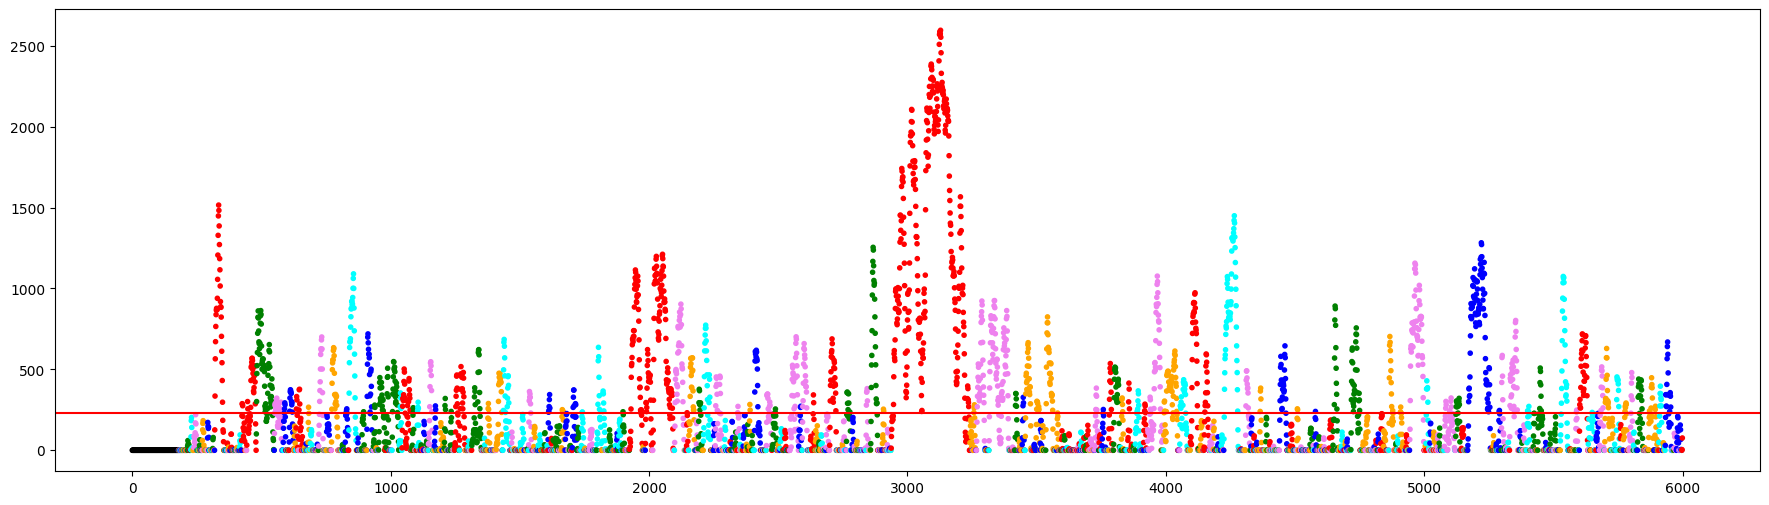

In [56]:
plt.figure(figsize=(22, 6))
plt.scatter(range(len(passenger_queue)), passenger_queue, c = cycle_colours, marker='.', label='Passenger Wait Times')
plt.axhline(y = avg_passengers_in_queue, color = 'r', linestyle = '-') 
# plt.plot(flight_arrivals, marker='o', label='Passenger Wait Times')